In [11]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image

plt.rcParams['figure.figsize'] = (16, 9)

In [12]:
img1 = cv2.imread('../data/fretboard_dataset/modified_images/28_0.png')
img2 = cv2.imread('../data/fretboard_dataset/modified_images/28_1.png')

In [13]:
# expects fretboard dataset to be in data folder on same level as tabs_generator folder
train_str = "test" # change to train or test to perform on respective data
dataset_path = "../data/fretboard_dataset/"
images_path = f"../data/fretboard_dataset/fretboard_frames_{train_str}/"
image_fns = os.listdir(images_path)
json_fn = os.path.join(dataset_path, f"fretboard_labels_{train_str}_vgg.json")
f = open(json_fn)
data = json.load(f) # data is dict of json contents
k = list(data.keys())

for i, fn in enumerate(image_fns):
    if i == 0:
        img_path = os.path.join(images_path, fn)
        out_path = os.path.join(images_path, "annotated_"+fn)
        img = np.asarray(Image.open(img_path)) # loads images w/ range of 0:255
        x_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_x"] # list of rectangle coordinates
        y_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_y"]
        x_list.pop(-1) # remove duplicate of first coordinate from end of lists
        y_list.pop(-1)
        poly_corners = np.asarray([list(zip(x_list, y_list))], dtype=np.int32) # repackage into np array w/ correct dtype
print(poly_corners)

[[[ 722  547]
  [ 707  628]
  [1403  651]
  [1403  582]]]


In [14]:
# First find the minX minY maxX and maxY of the polygon
minX = img1.shape[1]
maxX = -1
minY = img1.shape[0]
maxY = -1
for point in poly_corners[0]:

    x = point[0]
    y = point[1]

    if x < minX:
        minX = x
    if x > maxX:
        maxX = x
    if y < minY:
        minY = y
    if y > maxY:
        maxY = y

# Go over the points in the image if thay are out side of the emclosing rectangle put zero
# if not check if thay are inside the polygon or not
cropedImage = np.zeros_like(img1)
for y in range(0,img1.shape[0]):
    for x in range(0, img1.shape[1]):
        if x < minX or x > maxX or y < minY or y > maxY:
            continue

        if cv2.pointPolygonTest(np.asarray(poly_corners),(x,y),False) >= 0:
            cropedImage[y, x, 0] = img1[y, x, 0]
            cropedImage[y, x, 1] = img1[y, x, 1]
            cropedImage[y, x, 2] = img1[y, x, 2]

# Now we can crop again just the envloping rectangle

In [15]:
img1 = cropedImage

In [16]:
orb = cv2.ORB_create()
kps1, des1 = orb.detectAndCompute(img1, None)
kps2, des2 = orb.detectAndCompute(img2, None)

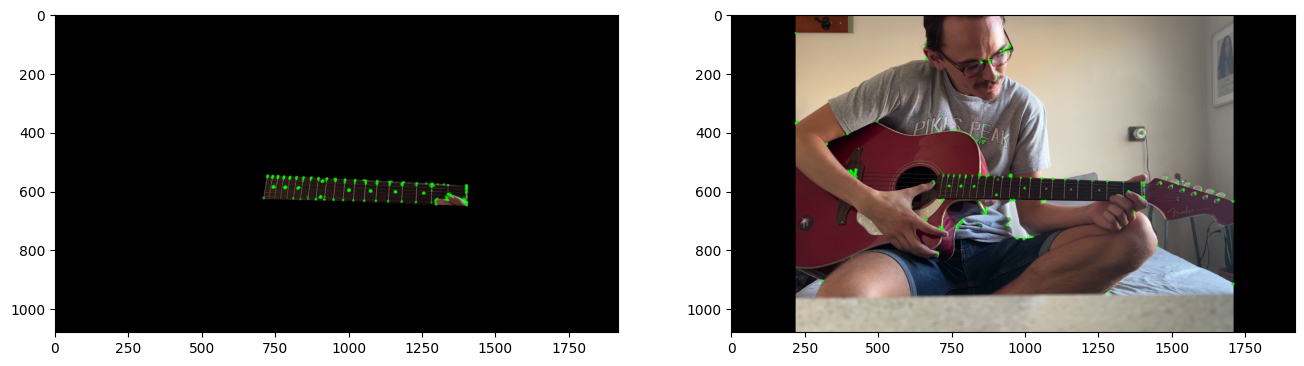

In [17]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

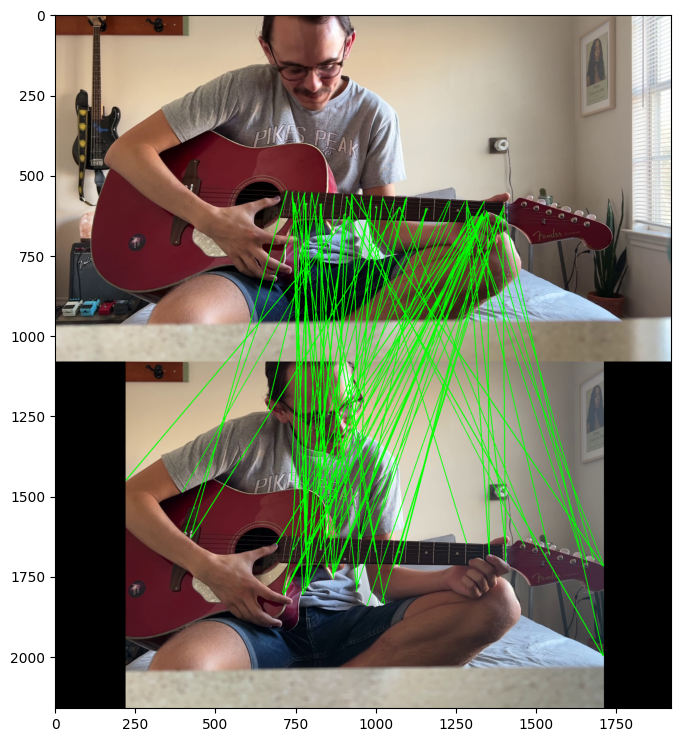

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming img1, kps1, des1, img2, kps2, des2 are your images, keypoints, and descriptors

# Create a Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors using the BFMatcher
matches = bf.match(des1, des2)

# Stack images vertically
stacked_img = cv2.vconcat([cv2.imread('../data/fretboard_dataset/fretboard_frames_test/28_0.png'), img2])

# Draw the matched lines on the stacked image
lines = []
for match in matches:
    pt1 = (int(kps1[match.queryIdx].pt[0]), int(kps1[match.queryIdx].pt[1]))
    pt2 = (int(kps2[match.trainIdx].pt[0]), int(kps2[match.trainIdx].pt[1] + img1.shape[0]))  # Shift the y-coordinate for the second image
    lines.append([pt1[0], pt1[1], pt2[0], pt2[1]])

# Remove lines that cross a large number of other lines
filtered_lines = []
filtered_idx = []
for i in range(len(lines)):
    crossing_count = 0
    for j in range(len(lines)):
        if i != j:
            x1, y1, x2, y2 = lines[i]
            x3, y3, x4, y4 = lines[j]
            # Check if line i crosses 70% of the other lines
            if (
        min(x1, x2) < max(x3, x4) and
        min(y1, y2) < max(y3, y4) and
        min(x3, x4) < max(x1, x2) and
        min(y3, y4) < max(y1, y2) and
        ((x1 - x2) * (y3 - y1) - (y1 - y2) * (x3 - x1)) * ((x1 - x2) * (y4 - y1) - (y1 - y2) * (x4 - x1)) < 0
    ):
                crossing_count += 1

    if crossing_count < .7 * len(lines):
        filtered_lines.append(lines[i])
    else:
        filtered_idx.append(i)

# removed filtered line matches


# Draw the filtered lines on the stacked image
for line in filtered_lines:
    pt1 = (int(line[0]), int(line[1]))
    pt2 = (int(line[2]), int(line[3]))
    cv2.line(stacked_img, pt1, pt2, (0, 255, 0), 2)
for line in filtered_idx:
    pt1 = (int(line[0]), int(line[1]))
    pt2 = (int(line[2]), int(line[3]))
    cv2.line(stacked_img, pt1, pt2, (255, 0, 0), 2)

# Display the stacked image with matches using matplotlib
plt.imshow(cv2.cvtColor(stacked_img, cv2.COLOR_BGR2RGB))
plt.show()


In [19]:
# Extract source and destination points
src_pts = np.array([kps1[match.queryIdx].pt for match in matches if matches.index(match) not in filtered_idx])
dst_pts = np.array([kps2[match.trainIdx].pt for match in matches if matches.index(match) not in filtered_idx])

# Find the homography matrix using RANSAC
M, mask = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC)

# Create a mask for inliers
matchesMask = mask.ravel().tolist()

# Get image dimensions
h, w, z = img1.shape

# Define the corners of the reference image
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

# Transform the corners using the homography matrix
dst = cv2.perspectiveTransform(pts, M)

# Draw the polygon on img2 to visualize the perspective transformation
img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)


The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images.

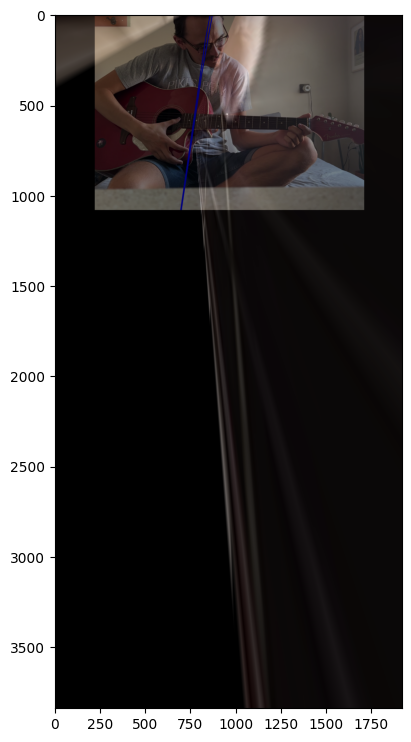

In [20]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, M)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()